# 06a Visualizing Weights

How can we figure out how our trained neural network is making its decisions?

One way is to examine the weights in the first layer.  The units in this layer have learned weighted sums of the inputs. The magnitudes of the weight values will tell us how significant each input is, and the signs of the weights will distinguish between negative and positive effects of each input.

We can use `matplotlib`'s `imshow` function to display a matrix of weights using pseudocolors.

To illustrate this, let's make some toy data, after importing the usual stuff.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import neuralnetworkA3 as nn

In [2]:
n_samples = 100

x1 = np.random.uniform(0, 1, n_samples)
x2 = np.random.uniform(-100, -80, n_samples)
x3 = np.random.uniform(1000, 2000, n_samples)
x4 = np.random.uniform(-1, 1, n_samples)

t1 = x1 ** 2
t2 = x3 + x4 * 1000

X = np.vstack((x1, x2, x3, x4)).T
T = np.vstack((t1, t2)).T

print(X.shape, T.shape)

(100, 4) (100, 2)


So, four inputs and two outputs. Let's try a network with one hidden layer of 10 units.

In [3]:
nnet = nn.NeuralNetwork(4, [10], 2)
nnet.train(X, T, 1000, 'scg')

SCG: Iteration 100 RMSE=0.01530
SCG: Iteration 200 RMSE=0.01119
SCG: Iteration 300 RMSE=0.00802
SCG: Iteration 400 RMSE=0.00379
SCG: Iteration 500 RMSE=0.00327
SCG: Iteration 600 RMSE=0.00297
SCG: Iteration 700 RMSE=0.00281
SCG: Iteration 800 RMSE=0.00266
SCG: Iteration 900 RMSE=0.00250
SCG: Iteration 1000 RMSE=0.00238


NeuralNetwork(4, [10], 2)

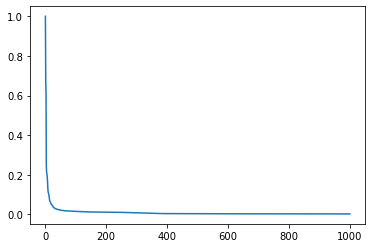

In [4]:
plt.plot(nnet.get_performance_trace());

We can plot the output versus input for the first target, since it is a function of just the first input component.

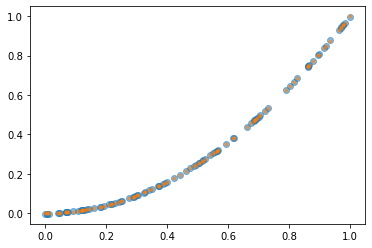

In [5]:
Y = nnet.use(X)
plt.plot(X[:, 0], Y[:, 0], 'o', alpha=0.5)
plt.plot(X[:, 0], T[:, 0], '.', alpha=0.5);

We can plot Y vs T for each output separately.

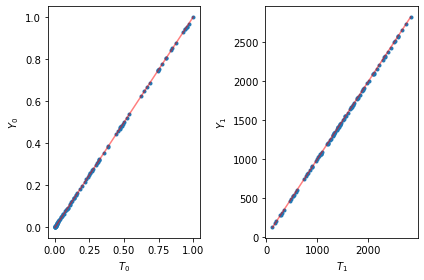

In [6]:
plt.subplot(1, 2, 1)
plt.plot(T[:, 0], Y[:, 0], '.')
TY = np.stack((T[:, 0], Y[:, 0]))
mn, mx = TY.min(), TY.max()
plt.plot([mn, mx], [mn, mx], 'r-', alpha=0.5)
plt.xlabel('$T_0$')
plt.ylabel('$Y_0$')

plt.subplot(1, 2, 2)
plt.plot(T[:, 1], Y[:, 1], '.')
TY = np.stack((T[:, 1], Y[:, 1]))
mn, mx = TY.min(), TY.max()
plt.plot([mn, mx], [mn, mx], 'r-', alpha=0.5)
plt.xlabel('$T_1$')
plt.ylabel('$Y_1$')

plt.tight_layout();

Now, let's look at the first layer weights.

We expect the first input to be significant, since $T_0$ depends only on it.  $T_1$ depends on the third and fourth inputs.

In [19]:
len(nnet.Ws)

2

In [20]:
W1 = nnet.Ws[0]
W1.shape

(5, 10)

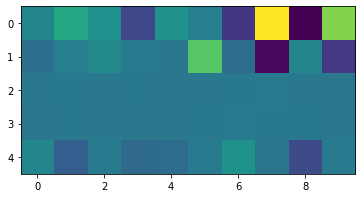

In [21]:
plt.imshow(W1)

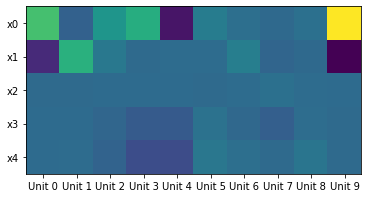

In [10]:
plt.imshow(W1)
n_inputs, n_units = W1.shape
x_labels = ['Unit {}'.format(i) for i in range(n_units)]
plt.xticks(list(range(n_units)), x_labels)
y_labels = ['x{}'.format(i) for i in range(n_inputs)]
plt.yticks(range(n_inputs), y_labels);

Now add a colorbar to help us interpret the colors.

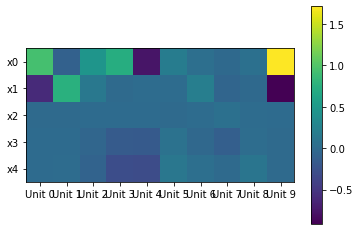

In [11]:
plt.imshow(W1)
n_inputs, n_units = W1.shape
x_labels = ['Unit {}'.format(i) for i in range(n_units)]
plt.xticks(list(range(n_units)), x_labels)
y_labels = ['x{}'.format(i) for i in range(n_inputs)]
plt.yticks(range(n_inputs), y_labels)

plt.colorbar();

These colors are hard to understand.  Make our own colorbar with white being zero weights.

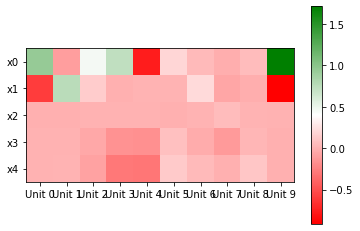

In [12]:
from  matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

plt.imshow(W1, cmap=cmap)
n_inputs, n_units = W1.shape
x_labels = ['Unit {}'.format(i) for i in range(n_units)]
plt.xticks(list(range(n_units)), x_labels)
y_labels = ['x{}'.format(i) for i in range(n_inputs)]
plt.yticks(range(n_inputs), y_labels)

plt.colorbar();

Not quite.  We want the color scale to have equal magnitude max and min values.

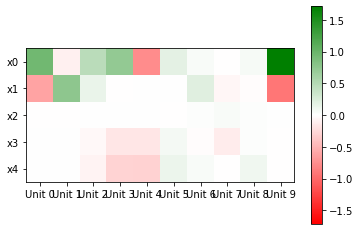

In [13]:
mx = np.max(np.abs(W1))

plt.imshow(W1, cmap=cmap, vmin=-mx, vmax=mx)
n_inputs, n_units = W1.shape
x_labels = ['Unit {}'.format(i) for i in range(n_units)]
plt.xticks(list(range(n_units)), x_labels)
y_labels = ['x{}'.format(i) for i in range(n_inputs)]
plt.yticks(range(n_inputs), y_labels)

plt.colorbar();

There.  Kind of what we expected.  $x_1$, $x_3$, and $x_4$, and the bias weight, $w_0$ are most significant.

We can add the output weight values in the x tick labels to see how each of the units are connected to the output layer.

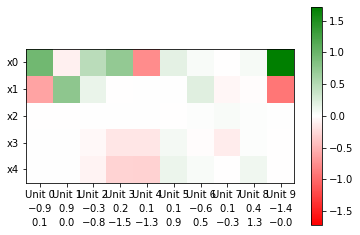

In [14]:
W2 = nnet.Ws[1]

mx = np.max(np.abs(W1))

plt.imshow(W1, cmap=cmap, vmin=-mx, vmax=mx)
n_inputs, n_units = W1.shape
x_labels = ['Unit {}\n${:.1f}$\n${:.1f}$'.format(i, W2[i+1, 0], W2[i+1, 1]) for i in range(n_units)]
plt.xticks(list(range(n_units)), x_labels)
y_labels = ['x{}'.format(i) for i in range(n_inputs)]
plt.yticks(range(n_inputs), y_labels)

plt.colorbar();

Why did I use dollar signs for the values in the x tick labels?

Now for even more fun!   Here is a function I use to draw neural networks with weight matrices!

In [15]:
import matplotlib.patches as pltpatch  # for Arc
import matplotlib.collections as pltcoll

def draw(W, inputNames = None, outputNames = None, scale = 1, gray = False):
    
    def isOdd(x):
        return x % 2 != 0

    # if inputNames is None:
    #     inputNames = ["$x_{}$".format(i) for i in range(1,W[0].shape[0])]

    nLayers = len(W)

    # calculate xlim and ylim for whole network plot
    #  Assume 4 characters fit between each wire
    #  -0.5 is to leave 0.5 spacing before first wire
    xlim = max(map(len,inputNames))/4.0 if inputNames else 1
    ylim = 0
    
    for li in range(nLayers):
        ni,no = W[li].shape  #no means number outputs this layer
        if not isOdd(li):
            ylim += ni + 0.5
        else:
            xlim += ni + 0.5

    ni,no = W[nLayers-1].shape  #no means number outputs this layer
    if isOdd(nLayers):
        xlim += no + 0.5
    else:
        ylim += no + 0.5

    # Add space for output names
    if outputNames:
        if isOdd(nLayers):
            ylim += 0.25
        else:
            xlim += round(max(map(len,outputNames))/4.0)

    ax = plt.gca()

    # changes from Jim Jazwiecki (jim.jazwiecki@gmail.com) CS480 student
    character_width_factor = 0.07
    padding = 2
    if inputNames:
        x0 = max([1, max(map(len, inputNames)) * (character_width_factor * 3.5)])
    else:
        x0 = 1
    y0 = 0 # to allow for constant input to first layer
    # First Layer
    if inputNames:
        # addx = max(map(len,inputNames))*0.1
        y = 0.55
        for n in inputNames:
            y += 1
            ax.text(x0 - (character_width_factor * padding), y, n, horizontalalignment="right", fontsize=20)
            # x0 = max([1,max(map(len,inputNames))/4.0])

    patches = []
    for li in range(nLayers):
        thisW = W[li]
        maxW = np.max(np.abs(thisW))
        ni,no = thisW.shape
        if not isOdd(li):
            # Even layer index. Vertical layer. Origin is upper left.
            # Constant input
            ax.text(x0-0.2, y0+0.5, '1', fontsize=20)
            for i in range(ni):
                ax.plot((x0,x0+no-0.5), (y0+i+0.5, y0+i+0.5),color='gray')
            # output lines
            for i in range(no):
                ax.plot((x0+1+i-0.5, x0+1+i-0.5), (y0, y0+ni+1),color='gray')
            # cell "bodies"
            xs = x0 + np.arange(no) + 0.5
            ys = np.array([y0+ni+0.5]*no)
            for x,y in zip(xs,ys):
                patches.append(pltpatch.RegularPolygon( (x,y-0.4), 3, 0.3, 0, color ='#555555'))
            # ax.scatter(xs,ys,marker='v',s=distToPoints(ax,1),c='gray')
            # weights
            if gray:
                colors = np.array(["black","gray"])[(thisW.flat >= 0)+0]
            else:
                colors = np.array(["red","green"])[(thisW.flat >= 0)+0]
            xs = np.arange(no)+ x0+0.5
            ys = np.arange(ni)+ y0 + 0.5
            # aWi = (np.abs(Wi) * scaleW)**2
            coords = np.meshgrid(xs,ys)
            #ax.scatter(coords[0],coords[1],marker='o',s=2*np.pi*aWi**2,c=colors)
            for x,y,w,c in zip(coords[0].flat,coords[1].flat, 
                               np.abs(thisW/maxW).flat, colors):
                patches.append(pltpatch.Rectangle((x-w/2, y-w/2), w,w, color=c))
            # ax.scatter(coords[0],coords[1],marker='s',s=distsToPoints(ax,thisW/maxW),c=colors)
            y0 += ni + 1
            x0 += -1 ## shift for next layer's constant input
        else:
            # Odd layer index. Horizontal layer. Origin is upper left.
            # Constant input
            # Reverse order of columns
            thisW = thisW.T
            ax.text(x0+0.5, y0-0.2, '1', fontsize=20)
            # input lines
            for i in range(ni):
                ax.plot((x0+i+0.5,  x0+i+0.5), (y0,y0+no-0.5),color='gray')
            # output lines
            for i in range(no):
                ax.plot((x0, x0+ni+1), (y0+i+0.5, y0+i+0.5),color='gray')
            # cell "bodies"
            xs = np.array([x0 + ni + 0.5]*no)
            ys = y0 + 0.5 + np.arange(no)
            for x,y in zip(xs,ys):
                patches.append(pltpatch.RegularPolygon( (x-0.4,y), 3, 0.3, -np.pi/2, color ='#555555'))
            # ax.scatter(xs,ys,marker='>',s=distToPoints(ax,1),c='gray')
            # weights
            if gray:
                colors = np.array(["black","gray"])[(thisW.flat >= 0)+0]
            else:
                colors = np.array(["red","green"])[(thisW.flat >= 0)+0]
            xs = np.arange(ni)+x0 + 0.5
            ys = np.arange(no)+y0 + 0.5
            coords = np.meshgrid(xs,ys)
            # aWi = (np.abs(Wi) * scaleW)**2
            #ax.scatter(coords[0],coords[1],marker='o',s=2*np.pi*aWi**2,c=colors)
            for x,y,w,c in zip(coords[0].flat,coords[1].flat, 
                               np.abs(thisW/maxW).flat, colors):
                patches.append(pltpatch.Rectangle((x-w/2, y-w/2), w,w, color=c))
            # ax.scatter(coords[0],coords[1],marker='s',s=distsToPoints(ax,thisW/maxW),c=colors)
            x0 += ni + 1
            y0 -= 1 ##shift to allow for next layer's constant input

    collection = pltcoll.PatchCollection(patches, match_original=True)
    ax.add_collection(collection)

    # Last layer output labels 
    if outputNames:
        if isOdd(nLayers):
            x = x0+1.5
            for n in outputNames:
                x += 1
                ax.text(x, y0+0.5, n, fontsize=20)
        else:
            y = y0+0.6
            for n in outputNames:
                y += 1
                ax.text(x0+0.2, y, n, fontsize=20)
    ax.axis([0,xlim, ylim,0])
    ax.axis('off')

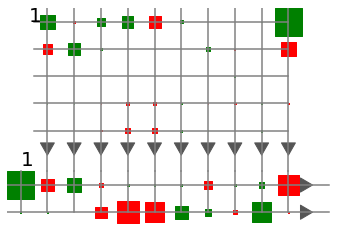

In [16]:
draw(nnet.Ws)

Now, let's combine the data generation, neural network training, and visualizations all together in one code cell so we can easily repeat with variations.

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

SCG: Iteration 100 RMSE=0.01504
SCG: Iteration 200 RMSE=0.01104
SCG: Iteration 300 RMSE=0.00809
SCG: Iteration 400 RMSE=0.00518
SCG: Iteration 500 RMSE=0.00422
SCG: Iteration 600 RMSE=0.00353
SCG: Iteration 700 RMSE=0.00297
SCG: Iteration 800 RMSE=0.00263
SCG: Iteration 900 RMSE=0.00246
SCG: Iteration 1000 RMSE=0.00231


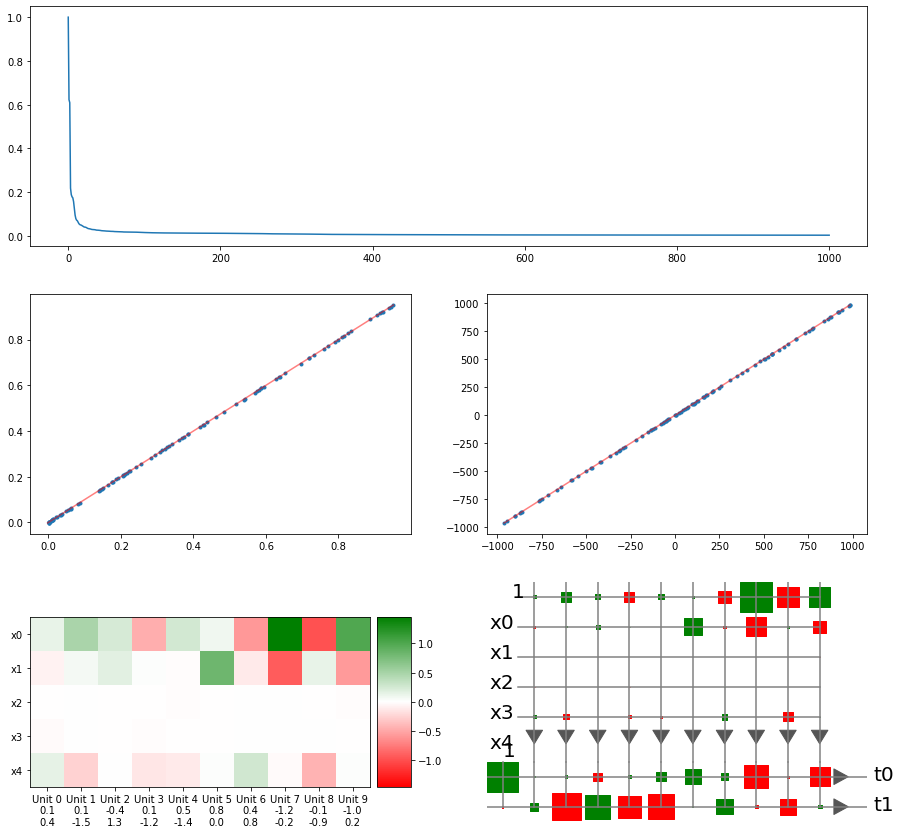

In [18]:
n_samples = 100
x1 = np.random.uniform(0, 1, n_samples)
x2 = np.random.uniform(-100, -80, n_samples)
x3 = np.random.uniform(1000, 2000, n_samples)
x4 = np.random.uniform(-1, 1, n_samples)

t1 = x1 ** 2
t2 = 0 * x3 + x4 * 1000

X = np.vstack((x1, x2, x3, x4)).T
T = np.vstack((t1, t2)).T


nnet = nn.NeuralNetwork(4, [10], 2)
nnet.train(X, T, 1000, 'scg')


plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(nnet.get_performance_trace())

Y = nnet.use(X)

plt.subplot(3, 2, 3)
plt.plot(T[:, 0], Y[:, 0], '.')
TY = np.stack((T[:, 0], Y[:, 0]))
mn, mx = TY.min(), TY.max()
plt.plot([mn, mx], [mn, mx], 'r-', alpha=0.5)

plt.subplot(3, 2, 4)
plt.plot(T[:, 1], Y[:, 1], '.')
TY = np.stack((T[:, 1], Y[:, 1]))
mn, mx = TY.min(), TY.max()
plt.plot([mn, mx], [mn, mx], 'r-', alpha=0.5)

W1 = nnet.Ws[0]
W2 = nnet.Ws[1]

plt.subplot(3, 2, 5)

mx = np.max(np.abs(W1))
# image = plt.imshow(W1, cmap='coolwarm', vmin=-mx, vmax=mx)
image = plt.imshow(W1, cmap=cmap, vmin=-mx, vmax=mx)
n_inputs, n_units = W1.shape
x_labels = ['Unit {}\n{:.1f}\n{:.1f}'.format(i, W2[i+1, 0], W2[i+1, 1]) for i in range(n_units)]
plt.xticks(list(range(n_units)), x_labels)
y_labels = ['x{}'.format(i) for i in range(n_inputs)]
plt.yticks(range(n_inputs), y_labels)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad=0.1)
plt.colorbar(image, cax=cax)

plt.subplot(3, 2, 6)


input_labels = ['x{}'.format(i) for i in range(n_inputs)]
n_outputs = T.shape[1]
output_labels = ['t{}'.format(i) for i in range(n_outputs)]
draw(nnet.Ws, inputNames = input_labels, outputNames = output_labels)

This should raise some questions in your brains!

- Can I interpret the functions learned in each hidden unit?
- Does the sign with which they connect to the output units make sense?
- How many units do we need in the first layer?
- How much variation is there in results from one run to the next?
- Can I reduce the number of units in the hidden layer by combining similar units?
